**Prédiction du succès d'une campagne de Marketing d'une banque**

**Description détaillée**
*L’analyse des données marketing est une problématique très classique des sciences des données appliquées dans les entreprises de service. Pour ce jeu de données, nous avons des données personnelles sur des clients d’une banque qui ont été “télémarketés” pour souscrire à un produit que l’on appelle un "dépôt à terme”. Lorsqu’un client souscrit à ce produit, il place une quantité d’argent dans un compte spécifique et ne pourra pas toucher ces fonds avant l’expiration du terme. En échange, le client reçoit des intérêts de la part de la banque à la fin du terme.*

Source - Le jeu de données est téléchargeable au lien suivant : https://www.kaggle.com/codestudiods/eda-and-model-building-bank-marketing-dataset

**Import des données**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()  # pour modifier le thème
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('bank.csv') 
print(df.head())

print('Nb de données manquantes par colonne :')
print(df.isna().sum(), '\n')

print(df.shape)  # donne la dimension
print(df.info()) # donne des infos générales sur le dataframe

   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  
Nb de données manquantes par colonne :
age          0
job          0
marital      0
education    0


**Description des variables**

**0- age :** âge du client

**1- job :** type d'emploi

**2- marital :** statut marital

**3- education :** niveau d'études

**4- default :** le client a-il eu un défaut de paiement sur un crédit ?

**5- balance :** montant des encours détenus par le client

**6- housing :** détention d'un prêt immobilier

**7- loan :** détention d'un prêt personnel

**8- contact :** canal de communication (lors du dernier contact de la campagne en cours)

**9- day :** jour du dernier contact de la campagne en cours

**10- month :** mois du dernier contact de la campagne en cours

**11- duration :** durée (en secondes) du dernier contact de la campagne en cours

**12- campaign :** nombre de contacts effectués au cours de cette campagne et pour ce client (inclut le dernier contact)

**13- pdays :** nombre de jours qui se sont écoulés depuis que le client a été contacté pour la dernière fois lors d'une campagne précédente

**14- previous :** nombre de contacts effectués avant cette campagne et pour ce client

**15- poutcome :** résultat de la campagne marketing précédente

**16- deposit :** le client a-il souscrit à un dépôt à terme?

**Nettoyage de la base de données**

*a) Raisonnement*

In [2]:
# Pour obtenir la distribution des variables quantitatives
print(df.describe())

# Pour obtenir l'étendue des variables catégorielles
for col in df.select_dtypes(include='object').columns:
    print(col)
    print(df[col].unique())
    
# Attention : pas de NAN dans le Dataframe mais 4 variables contiennent des "unknown" : job, education, contact et poutcome
# campaign semblent avoir des valeurs aberrantes pour certains clients qui seront retirés de la modélisation.

# Signification du -1 pour pdays (nombre de jours qui se sont écoulés depuis que le client a été contacté pour la dernière fois lors d'une campagne précédente):
print(pd.crosstab(df['pdays'],df['previous'],normalize=1))
# Lorsque pdays=-1, previous est toujours égal à 0. Cela signifie que les clients n'ont pas été ciblés lors de la précédente campagne.

print(pd.crosstab(df['poutcome'],df['previous']))
# Le "unknown" de poutcome signifie pour la majorité des cas (toute la base sauf 2 clients) que les clients n'ont pas été contactés lors de la dernière campagne (previous = 0).
# Nous renommerons cette modalité 'unknown' en 'not contacted previously'
# Les deux clients ayant participé à la campagne précédente (previous = 0) sans avoir de résultat disponible (poutcome = 'unknown') seront retirer de la modélisation.

print(df['previous'].value_counts(normalize=True))
# Les variables pdays, previous et poutcome concernent les clients ayant participé à la précédente campagne marketing (soit 25% des clients)
# Pour les autres clients, les valeurs "-1", "0", "unknown" sont attribués respectivement à pdays, previous, poutcome

from scipy.stats import pearsonr
print(pd.DataFrame(pearsonr(df['pdays'], df['previous']), index=['pearson_coeff','p-value'], columns=['resultat_test_corrélation_pdays_previous']))
# De plus les variables pdays et previous sont corrélées entre elles.
# Nous estimons que, parmi ces 3 variables, seule poutcome (résultat de la précédente campagne marketing) est pertinente pour notre modèle.
# Nous retirerons pdays et previous de notre modélisation.

                age       balance           day      duration      campaign  \
count  11162.000000  11162.000000  11162.000000  11162.000000  11162.000000   
mean      41.231948   1528.538524     15.658036    371.993818      2.508421   
std       11.913369   3225.413326      8.420740    347.128386      2.722077   
min       18.000000  -6847.000000      1.000000      2.000000      1.000000   
25%       32.000000    122.000000      8.000000    138.000000      1.000000   
50%       39.000000    550.000000     15.000000    255.000000      2.000000   
75%       49.000000   1708.000000     22.000000    496.000000      3.000000   
max       95.000000  81204.000000     31.000000   3881.000000     63.000000   

              pdays      previous  
count  11162.000000  11162.000000  
mean      51.330407      0.832557  
std      108.758282      2.292007  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%       20.750000      1.000000  


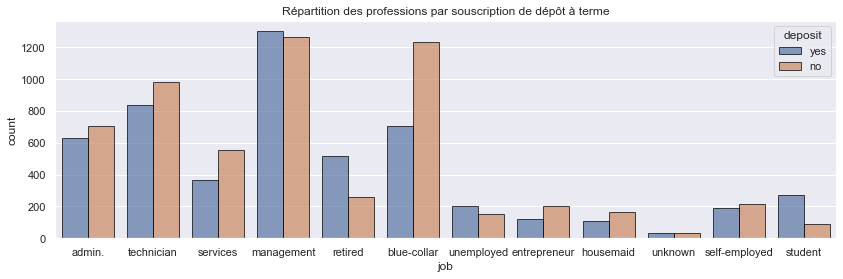

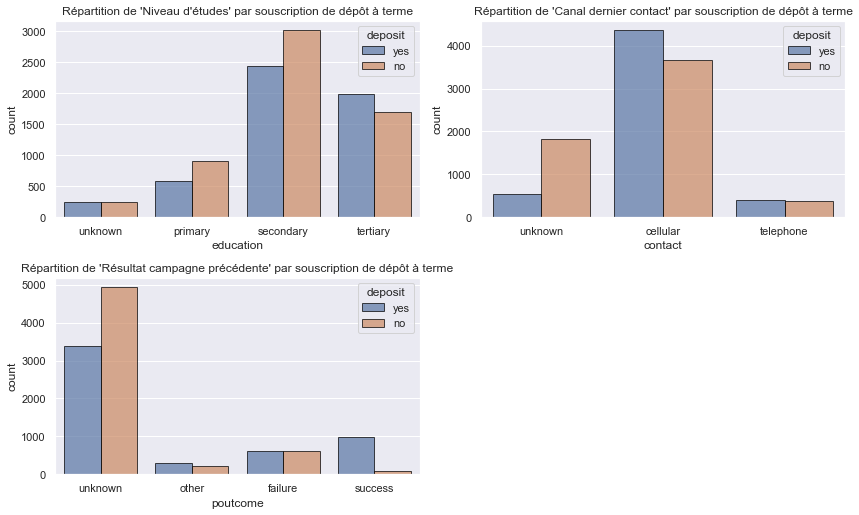

In [3]:
# Visualisation des unknown
# Variables explicatives qualitatives (comportant des unknown) 
features_quali_1=["education","contact","poutcome"]
noms_var_quali_1=["Niveau d'études","Canal dernier contact","Résultat campagne précédente"]

# Countplot des variables explicatives qualitatives comportant des unknown en fonction de la variable cible "deposit"
plt.figure(figsize=[14,4])
sns.countplot(x='job', hue='deposit',edgecolor="black", alpha=0.7, data=df)
plt.title("Répartition des professions par souscription de dépôt à terme")
plt.show()

plt.figure(figsize=[12,14])
n=1
for f,g in zip(features_quali_1,noms_var_quali_1):
    plt.subplot(4,2,n)
    if  f=="education":
        sns.countplot(x=f, hue='deposit', edgecolor="black", alpha=0.7, data=df,order=("unknown","primary","secondary","tertiary"))
    
    else:
        sns.countplot(x=f, hue='deposit', edgecolor="black", alpha=0.7, data=df)
    plt.title("Répartition de " + "'" + g + "'"+ " par souscription de dépôt à terme")
    n=n+1
plt.tight_layout()
plt.show()

# Pour job et education, les modalités 'unknown' n’influent pas particulièrement sur deposit. 
# Nous conservons cette modalité, qui sera renommée en : 'other' pour ces deux variables.

# Pour contact, la modalité 'unknown' semble influer négativement sur deposit par rapport aux autres. 
# Nous concluons que cette modalité est un moyen de contact autre que téléphonique et sera renommée en : other type of contact

La valeur à partir de laquelle les données sont considérées comme aberrante est : 9.313614384005117


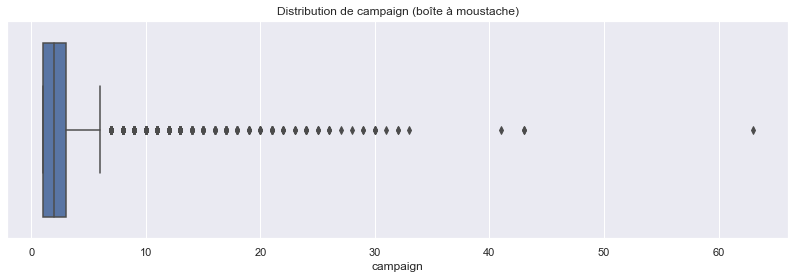

In [4]:
# Boîte à moustache pour visualiser les valeurs extremes de campaign
plt.figure(figsize=[14,4])
sns.boxplot(df['campaign'])
plt.title("Distribution de campaign (boîte à moustache)");
# Nous confirmons la présence de nombreuses valeurs extrêmes.

# Bonne pratique : une observation est considérée comme une valeur extrême si elle est éloignée de plus de 2,5 écarts types de la moyenne de distribution.
ecart_type = df['campaign'].std()
intervalle = [df['campaign'].mean() - ecart_type * 2.5, df['campaign'].mean() + ecart_type * 2.5]
print("La valeur à partir de laquelle les données sont considérées comme aberrante est :", intervalle[1])
# Ici, toutes les valeurs à partir de 10 et au delà seront donc considérées comme extrêmes. Ces clients ne seront pas pris en compte dans la modélisation.

*b) Liste des modifications*

In [4]:
# Réalisation des modifications évoquées précédemment sur un nouveau dataframe nommé df_clean
df_clean = df

# On renomme les 'unknown' de job en 'other'
df_clean['job'].replace('unknown', 'other', inplace=True)
print(df_clean['job'].value_counts())

# On renomme les 'unknown' de education en 'other'
df_clean['education'].replace('unknown', 'other', inplace=True)
print(df_clean['education'].value_counts())

# On renomme les 'unknown' de contact en 'other type of contact'
df_clean['contact'].replace('unknown', 'other type of contact', inplace=True)
print(df_clean['contact'].value_counts())

# On supprime les deux clients ayant participé à la campagne précédente mais n'ayant pas de résultat renseignée à poutcome
df_clean.drop(df_clean.loc[ (df_clean['previous'] > 0)
              & (df_clean['poutcome'] == 'unknown') ].index, inplace=True)
print(df_clean.info())
# 2 lignes supprimées

# On renomme les 'unknown' de poutcome en 'not contacted previously'
df_clean['poutcome'].replace('unknown', 'not contacted previously', inplace=True)
print(df_clean['poutcome'].value_counts())

# On supprime les clients ayant des valeurs aberrantes dans campaign (campaign >= 10)
df_clean.drop(df_clean.loc[(df_clean['campaign'] >= 10)].index, inplace=True)
print(df_clean.info())
# 262 lignes supprimées

# Avant la modélisation, supprimer les variables pdays et previous
# df_clean.drop(['pdays', 'previous'], axis = 1, inplace = True)


management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
other              70
Name: job, dtype: int64
secondary    5476
tertiary     3689
primary      1500
other         497
Name: education, dtype: int64
cellular                 8042
other type of contact    2346
telephone                 774
Name: contact, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11160 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11160 non-null  int64 
 1   job        11160 non-null  object
 2   marital    11160 non-null  object
 3   education  11160 non-null  object
 4   default    11160 non-null  object
 5   balance    11160 non-null  int64 
 6   housing    11160 non-null  object
 7   loan       11160 non-null  

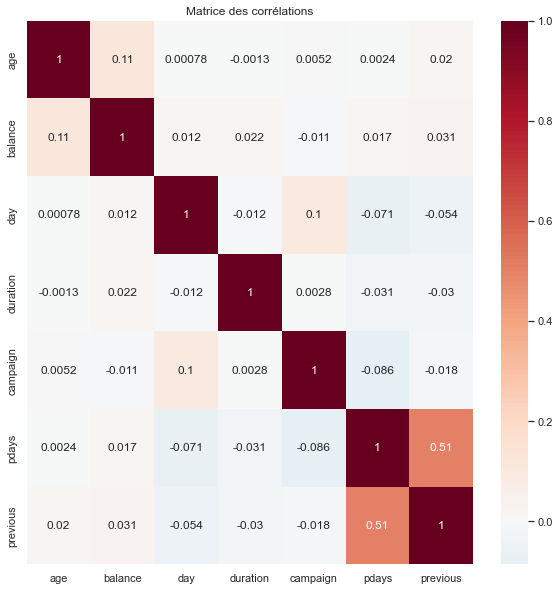

In [5]:
# MATRICE DES CORRELATIONS
plt.figure(figsize=(10, 10))
sns.heatmap(df_clean.corr(), annot=True, cmap='RdBu_r', center=0)
plt.title('Matrice des corrélations');

# Comme évoqué précédemment, les variables pdays et previous sont corrélées entre elles. 
# Le reste des variables ne présentent pas particulièrement de corrélation les unes avec les autres

**Data vizualisation**

*a) Caractéristiques socio-démographiques des clients*

In [6]:
# Répartition de la variable cible
df_clean["deposit"].value_counts()

no     5672
yes    5226
Name: deposit, dtype: int64

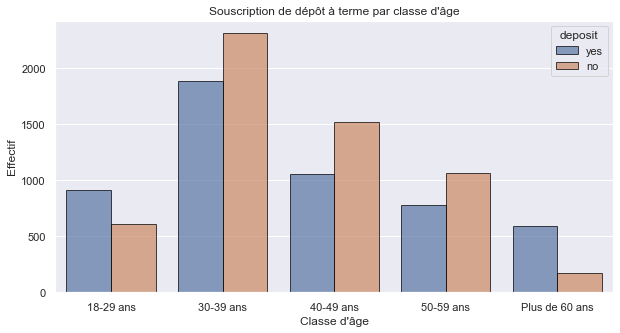

Test Anova entre les variables age et deposit :
P-value : 0.0003651330585839248
Statistique de Fisher : 12.710664963933654
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle l'âge n'influe pas sur deposit

Taux de souscription par classe d'âge
classe_age  18-29 ans  30-39 ans  40-49 ans  50-59 ans  Plus de 60 ans
deposit                                                               
no           0.400527   0.550179    0.59098   0.577657        0.227273
yes          0.599473   0.449821    0.40902   0.422343        0.772727


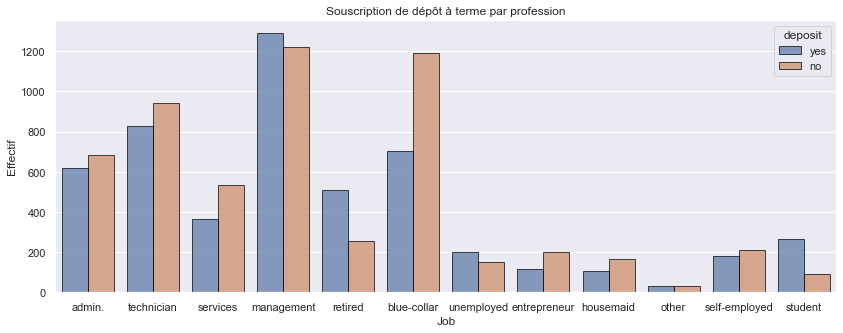

Test du Khi 2 entre les variables job et deposit :
P-value:  1.2956689653639255e-71
V de Cramer :  0.18035427173336158
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle job n'influe pas sur deposit

Taux de souscription par profession
job        admin.  blue-collar  entrepreneur  housemaid  management  other  \
deposit                                                                      
no       0.523444     0.629551      0.628931   0.602941     0.48625    0.5   
yes      0.476556     0.370449      0.371069   0.397059     0.51375    0.5   

job       retired  self-employed  services   student  technician  unemployed  
deposit                                                                       
no       0.334635       0.534351  0.592881  0.252101    0.531374    0.430199  
yes      0.665365       0.465649  0.407119  0.747899    0.468626    0.569801  


In [7]:
# Countplot des variables explicatives en fonction de la variable cible "deposit" avec confirmation des dépendances
#grâce aux tests statistiques

# AGE

# Diagramme en barre des classes d'âge en fonction de la variable cible "deposit"
plt.figure(figsize=(10,5))
df_clean["classe_age"]=pd.cut(df_clean.age,bins=[18,29,39,49,59,95],labels=['18-29 ans','30-39 ans','40-49 ans','50-59 ans','Plus de 60 ans'])
sns.countplot(x="classe_age",data=df_clean, edgecolor="black", alpha=0.7,hue="deposit")
plt.title("Souscription de dépôt à terme par classe d'âge")
plt.xlabel("Classe d'âge")
plt.ylabel('Effectif')
plt.show()

# Test ANOVA sur "age" et "deposit"
import statsmodels.api 
result = statsmodels.formula.api.ols('age ~ deposit', data=df_clean).fit()
table = statsmodels.api.stats.anova_lm(result)
print("Test Anova entre les variables age et deposit :")
print("P-value :",table.loc[table.index[0], 'PR(>F)'])
print("Statistique de Fisher :",table.loc[table.index[0], 'F'])
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle l'âge n'influe pas sur deposit")
print("")
print("Taux de souscription par classe d'âge")
print(pd.crosstab(df_clean["deposit"],df_clean["classe_age"],normalize = 1))


# JOB

# Diagramme en barre de "job" en fonction de la variable cible "deposit"
plt.figure(figsize=[14,5])
sns.countplot(x='job', hue='deposit',edgecolor="black", alpha=0.7, data=df_clean)
plt.title("Souscription de dépôt à terme par profession")
plt.xlabel("Job")
plt.ylabel('Effectif')
plt.show()

# Test du Khi 2 de la variable "job"
from scipy.stats import chi2_contingency
def V_Cramer(table, N):
    stat_chi2 = chi2_contingency(table)[0]
    k = table.shape[0]
    r = table.shape[1]
    phi = max(0,(stat_chi2/N)-((k-1)*(r-1)/(N-1)))
    k_corr = k - (np.square(k-1)/(N-1))
    r_corr = r - (np.square(r-1)/(N-1))
    return np.sqrt(phi/min(k_corr - 1,r_corr - 1))

table = pd.crosstab(df_clean['job'],df_clean['deposit']) 

resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print("Test du Khi 2 entre les variables job et deposit :")
print("P-value: ", p_valeur)
print("V de Cramer : ", V_Cramer(table, df_clean.shape[0]))
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle job n'influe pas sur deposit")

print("")
print("Taux de souscription par profession")
print(pd.crosstab(df_clean["deposit"],df_clean["job"],normalize = 1))


Les 18-29 ans et les plus de 60 ans semblent plus appétents au dépôt à terme.
Ce qui est confirmé par la répartition des professions : en effet, les étudiants et les retraités semblent plus enclins que les autres professions à souscrire à un dépôt à terme.

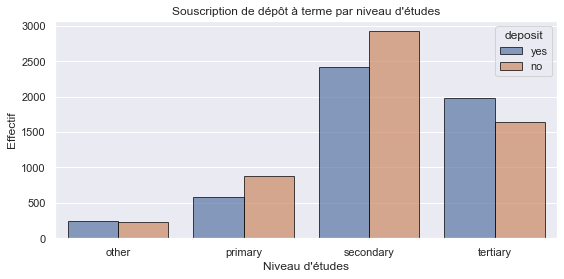

Test du Khi 2 entre les variables education et deposit :
P-value:  3.59638007309478e-26
V de Cramer :  0.10429837357563757
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle education n'influe pas sur deposit


In [8]:
# NIVEAU D'ETUDES (education)

# Diagramme en barre de "education" en fonction de la variable cible "deposit"
plt.figure(figsize=[9,4])
sns.countplot(x='education', hue='deposit',edgecolor="black", alpha=0.7, data=df_clean,order=("other","primary","secondary","tertiary"))
plt.title("Souscription de dépôt à terme par niveau d'études")
plt.xlabel("Niveau d'études")
plt.ylabel('Effectif')
plt.show()

# Test du Khi 2 de la variable "education"
table = pd.crosstab(df_clean['education'],df_clean['deposit']) 
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print("Test du Khi 2 entre les variables education et deposit :")
print("P-value: ", p_valeur)
print("V de Cramer : ", V_Cramer(table, df_clean.shape[0]))
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle education n'influe pas sur deposit")


Lorsque les clients ont un niveau d'études supérieur, le taux de souscription au dépôt à terme est plus important.

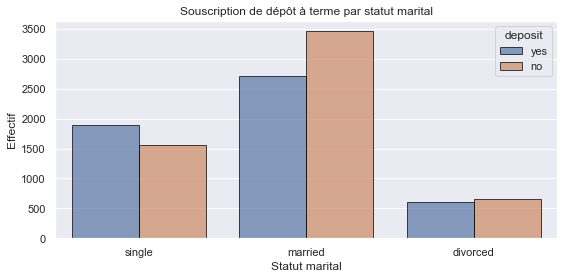

Test du Khi 2 entre les variables marital et deposit :
P-value:  2.002884634304137e-23
V de Cramer :  0.09699984942750176
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le statut marital n'influe pas sur deposit


In [9]:
# STATUT MARITAL (marital)

# Diagramme en barre de "marital" en fonction de la variable cible "deposit"
plt.figure(figsize=[9,4])
sns.countplot(x='marital', hue='deposit',edgecolor="black", alpha=0.7, data=df_clean,order=("single","married","divorced"))
plt.title("Souscription de dépôt à terme par statut marital")
plt.xlabel("Statut marital")
plt.ylabel('Effectif')
plt.show()

# Test du Khi 2 de la variable "marital"
table = pd.crosstab(df_clean['marital'],df_clean['deposit']) 
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print("Test du Khi 2 entre les variables marital et deposit :")
print("P-value: ", p_valeur)
print("V de Cramer : ", V_Cramer(table, df_clean.shape[0]))
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le statut marital n'influe pas sur deposit")


Les personnes célibataires souscrivent davantage à un dépôt à terme que celles mariées ou divorcées

*b) Equipement bancaire des clients*

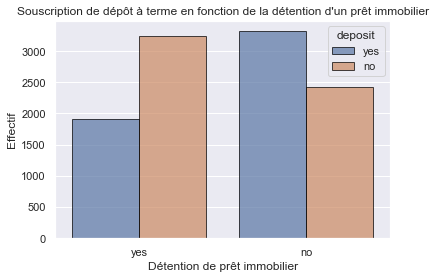

Test du Khi 2 entre les variables housing et deposit :
P-value:  3.166733634839059e-104
V de Cramer :  0.20746454019684335
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle la détention de prêt immobilier n'influe pas sur deposit


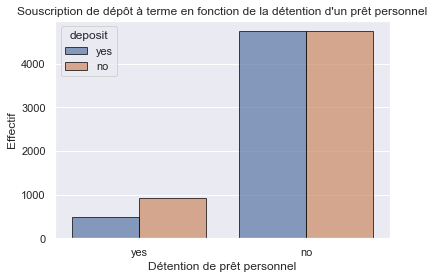

Test du Khi 2 entre les variables loan et deposit :
P-value:  2.7555952568071877e-29
V de Cramer :  0.10719608959270482
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle la détention de prêt personnel n'influe pas sur deposit

Taux de souscription par détention de prêt
pret           no       yes
deposit                    
no       0.396421  0.631232
yes      0.603579  0.368768


In [10]:
# DETENTION DE PRET IMMOBILIER (housing)

# Diagramme en barre de "housing" en fonction de la variable cible "deposit"
plt.figure(figsize=[6,4])
sns.countplot(x='housing', hue='deposit',edgecolor="black", alpha=0.7, data=df_clean)
plt.title("Souscription de dépôt à terme en fonction de la détention d'un prêt immobilier")
plt.xlabel("Détention de prêt immobilier")
plt.ylabel('Effectif')
plt.show()

# Test du Khi 2 de la variable "housing"
table = pd.crosstab(df_clean['housing'],df_clean['deposit']) 
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print("Test du Khi 2 entre les variables housing et deposit :")
print("P-value: ", p_valeur)
print("V de Cramer : ", V_Cramer(table, df_clean.shape[0]))
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle la détention de prêt immobilier n'influe pas sur deposit")

# DETENTION DE PRET PERSONNEL (loan)

# Diagramme en barre de "loan" en fonction de la variable cible "deposit"
plt.figure(figsize=[6,4])
sns.countplot(x='loan', hue='deposit',edgecolor="black", alpha=0.7, data=df_clean,order=("yes","no"))
plt.title("Souscription de dépôt à terme en fonction de la détention d'un prêt personnel")
plt.xlabel("Détention de prêt personnel")
plt.ylabel('Effectif')
plt.show()

# Test du Khi 2 de la variable "loan"
table = pd.crosstab(df_clean['loan'],df_clean['deposit']) 
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print("Test du Khi 2 entre les variables loan et deposit :")
print("P-value: ", p_valeur)
print("V de Cramer : ", V_Cramer(table, df_clean.shape[0]))
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle la détention de prêt personnel n'influe pas sur deposit")

df_clean.loc[(df_clean['housing'] == 'yes') | (df_clean['loan'] == 'yes'),'pret'] = 'yes' 
df_clean['pret'] = df_clean['pret'].fillna('no')
print("")
print("Taux de souscription par détention de prêt")
print(pd.crosstab(df_clean["deposit"],df_clean["pret"],normalize = 1))



Les personnes qui ne détiennent pas de prêt immobilier souscrivent d'avantage à un dépôt à terme.
De même pour le prêt personnel, les personnes qui ne détiennent pas de prêt personnel sont plus enclin à souscrire à un dépôt à terme.
Les clients qui n'ont aucun prêt ont un taux de sousption à un dépôt à terme de 60%

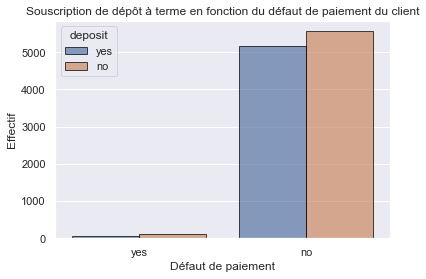

In [12]:
# DEFAUT DE PAIEMENT (default)

# Diagramme en barre de "default" en fonction de la variable cible "deposit"
plt.figure(figsize=[6,4])
sns.countplot(x='default', hue='deposit',edgecolor="black", alpha=0.7, data=df_clean,order=("yes","no"))
plt.title("Souscription de dépôt à terme en fonction du défaut de paiement du client")
plt.xlabel("Défaut de paiement")
plt.ylabel('Effectif')
plt.show()


La base de clients ne comporte qu'une très faible minorité de personnes en défaut de paiement (1,5% de la base). 
De plus, la variable "default" n'influe pas particulièrement sur deposit, cette variable sera à supprimer de la modélisation

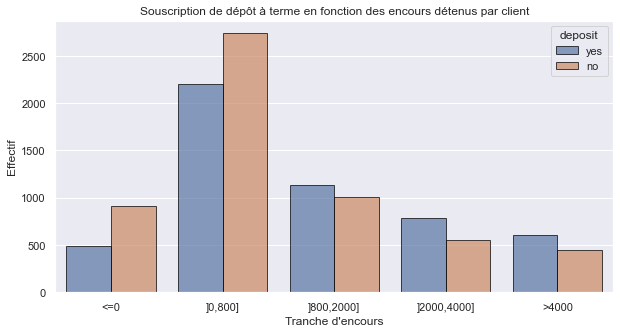

Test Anova entre les variables balance et deposit :
P-value : 5.213050774898898e-17
Statistique de Fisher : 70.48455893035364
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle les encours des clients n'influent pas sur deposit


balance                          
         median         mean   min    max
deposit                                  
no        418.0  1285.483780 -6847  66653
yes       733.0  1803.775354 -3058  81204

In [13]:
# ENCOURS DETENUS PAR LE CLIENT (balance)

plt.figure(figsize=(10,5))
df_clean["classe_balance"]=pd.cut(df_clean.balance,bins=[-7000,0,800,2000,4000,90000],labels=['<=0',']0,800]',']800,2000]',']2000,4000]', ">4000"])
sns.countplot(x="classe_balance",data=df_clean, edgecolor="black", alpha=0.7,hue="deposit")
plt.title("Souscription de dépôt à terme en fonction des encours détenus par client")
plt.xlabel("Tranche d'encours")
plt.ylabel('Effectif')
plt.show()

# Test ANOVA sur "balance"
import statsmodels.api 
result = statsmodels.formula.api.ols('balance ~ deposit', data=df_clean).fit()
table = statsmodels.api.stats.anova_lm(result)
print("Test Anova entre les variables balance et deposit :")
print("P-value :",table.loc[table.index[0], 'PR(>F)'])
print("Statistique de Fisher :",table.loc[table.index[0], 'F'])
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle les encours des clients n'influent pas sur deposit")

df_clean.groupby(['deposit']).agg({'balance': ['median', 'mean', 'min', 'max']})


Les clients ayant des encours les plus élevés semblent plus intéréssés par la souscription d'un dépôt à terme.
A partir de 800 d'encours, la proportion de clients qui souscrivent à un dépôt à terme dépasse celle des non souscripteurs. L'encours médian des clients n'ayant pas souscrit est de 418 euros vs 733 euros pour ceux qui ont souscrit

*c) Caractéristiques de la campagne*

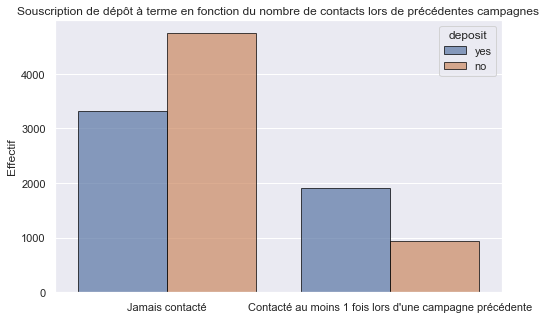

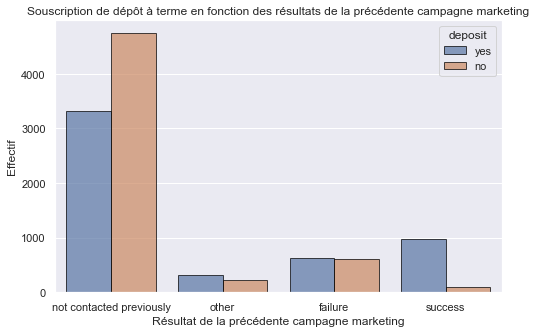

Test du Khi 2 entre les variables poutcome et deposit :
P-value:  1.0287232490003575e-210
V de Cramer :  0.29842512215102807
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le résultat de la précdente campagne marketing n'influe pas sur deposit
poutcome   failure  not contacted previously     other   success
deposit                                                         
no        0.496333                  0.587798  0.428305  0.086916
yes       0.503667                  0.412202  0.571695  0.913084


In [44]:
# Lien avec la précédente campagne

# NB DE CONTACTS LORS DE LA PRECEDENTE CAMPAGNE MARKETING (previous)

plt.figure(figsize=(8,5))
df_clean["classe_previous"]=pd.cut(df_clean.previous,bins=[-1,0,58],labels=["Jamais contacté","Contacté au moins 1 fois lors d'une campagne précédente"])
sns.countplot(x="classe_previous",data=df_clean,edgecolor="black",alpha=0.7,hue="deposit")
plt.title("Souscription de dépôt à terme en fonction du nombre de contacts lors de précédentes campagnes")
plt.xlabel('')
plt.ylabel('Effectif')
plt.show()

# RESULTAT DE LA PRECEDENTE CAMPAGNE MARKETING (poutcome)

# Diagramme en barre de "poutcome" en fonction de la variable cible "deposit"
plt.figure(figsize=[8,5])
sns.countplot(x='poutcome', hue='deposit',edgecolor="black", alpha=0.7, data=df_clean)
plt.title("Souscription de dépôt à terme en fonction des résultats de la précédente campagne marketing")
plt.xlabel("Résultat de la précédente campagne marketing")
plt.ylabel('Effectif')
plt.show()

# Test du Khi 2 de la variable "poutcome"
table = pd.crosstab(df_clean['poutcome'],df_clean['deposit']) 
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print("Test du Khi 2 entre les variables poutcome et deposit :")
print("P-value: ", p_valeur)
print("V de Cramer : ", V_Cramer(table, df_clean.shape[0]))
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le résultat de la précdente campagne marketing n'influe pas sur deposit")

print(pd.crosstab(df_clean["deposit"],df_clean["poutcome"],normalize = 1))



Les clients déjà contactés lors de la précédente campagne sont plus susceptibles de souscrire à un dépôt à terme.
Et plus précisément, les clients ayant eu un succès lors de la précédente campagne marketing ont une probabilité bien plus élevée de souscrire au dépôt à terme : en effet, 91% des clients ayant souscrit lors de la précédente campagne marketing vont à nouveau souscrire lors de la campagne actuelle. Alors que les clients qui n'ont pas été contactés lors de la précédente campagne ont un taux de souscription de 41%.


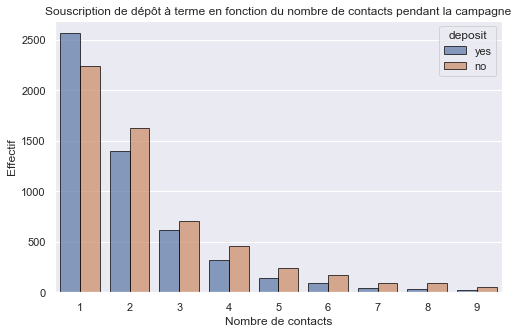

Test Anova entre les variables campaign et deposit :
P-value : 2.4812697165010813e-34
Statistique de Fisher : 150.3219376150664
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le nombre de contacts n'influe pas sur deposit


In [45]:
# NB DE CONTACTS DURANT LA CAMPAGNE ACTUELLE (campaign)

# Diagramme en barre de "campaign" en fonction de la variable cible "deposit"
plt.figure(figsize=[8,5])
sns.countplot(x='campaign', hue='deposit',edgecolor="black", alpha=0.7, data=df_clean)
plt.title("Souscription de dépôt à terme en fonction du nombre de contacts pendant la campagne")
plt.xlabel("Nombre de contacts")
plt.ylabel('Effectif')
plt.show()

# Test Anova entre campaign et deposit
result = statsmodels.formula.api.ols('campaign ~ deposit', data=df_clean).fit()
table = statsmodels.api.stats.anova_lm(result)
print("Test Anova entre les variables campaign et deposit :")
print("P-value :",table.loc[table.index[0], 'PR(>F)'])
print("Statistique de Fisher :",table.loc[table.index[0], 'F'])
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le nombre de contacts n'influe pas sur deposit")


Les clients qui n'ont été appelés qu'une seule fois au cours de la campagne semblent avoir de meilleurs taux de souscription

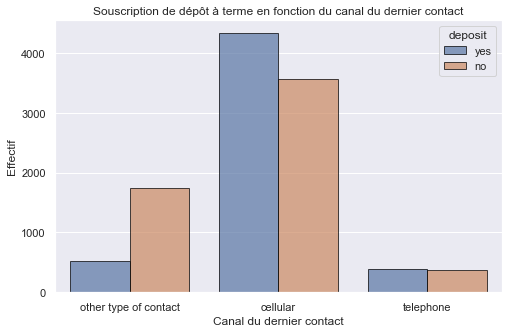

Test du Khi 2 entre les variables contact et deposit :
P-value:  9.04614812906508e-159
V de Cramer :  0.25808344878583234
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le canal du dernier contact n'influe pas sur deposit


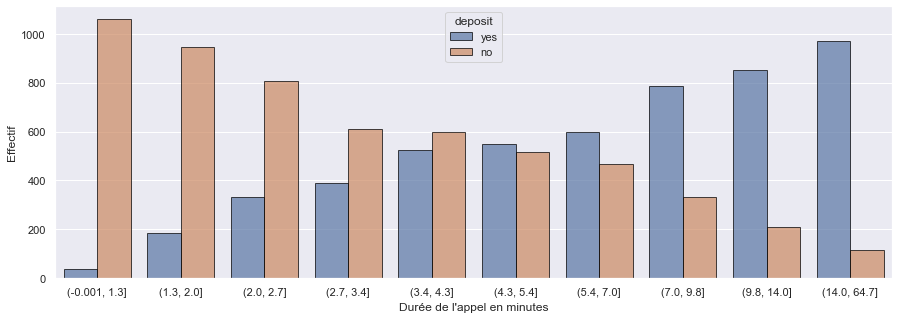

Test Anova entre les variables duration et deposit :
P-value : 0.0
Statistique de Fisher : 2675.4072534173915
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle la durée de l'appel n'influe pas sur deposit


In [46]:
# DERNIER CONTACT

# CANAL DU DERNIER CONTACT (contact)

# Diagramme en barre de "contact" en fonction de la variable cible "deposit"
plt.figure(figsize=[8,5])
sns.countplot(x='contact', hue='deposit',edgecolor="black", alpha=0.7, data=df_clean)
plt.title("Souscription de dépôt à terme en fonction du canal du dernier contact")
plt.xlabel("Canal du dernier contact")
plt.ylabel('Effectif')
plt.show()

# Test du Khi 2 de la variable "contact"
table = pd.crosstab(df_clean['contact'],df_clean['deposit']) 
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print("Test du Khi 2 entre les variables contact et deposit :")
print("P-value: ", p_valeur)
print("V de Cramer : ", V_Cramer(table, df_clean.shape[0]))
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le canal du dernier contact n'influe pas sur deposit")

# DUREE DU DERNIER CONTACT (duration)
df_clean['duration_mn'] = df_clean['duration'].apply(lambda n:n/60).round(1)

plt.figure(figsize=(15,5))
df_clean['decile_duration'] = pd.qcut(df_clean['duration_mn'], q=10)
sns.countplot(x="decile_duration",data=df_clean,edgecolor="black", alpha=0.7,hue="deposit")
plt.xlabel("Durée de l'appel en minutes")
plt.ylabel('Effectif')
plt.show()

# Test Anova entre duration et deposit
result = statsmodels.formula.api.ols('duration ~ deposit', data=df_clean).fit()
table = statsmodels.api.stats.anova_lm(result)
print("Test Anova entre les variables duration et deposit :")
print("P-value :",table.loc[table.index[0], 'PR(>F)'])
print("Statistique de Fisher :",table.loc[table.index[0], 'F'])
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle la durée de l'appel n'influe pas sur deposit")




Le taux de souscription à un dépôt à terme est meilleur chez les clients ayant eu un contact sur leur téléphone mobile.
Par ailleurs, le taux de souscription semble très corrélé à la durée du dernier appel : plus cet appel est long, plus le client a de chance de souscrire (avec une statistique de Fishier importante de 2675).
72% des appels qui ont duré plus de 5 mn ont donné lieu à une souscription de produit (contre 29% des appels de moins de 5 mn)

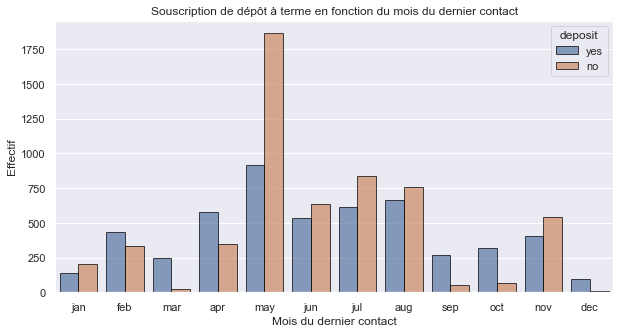

Test du Khi 2 entre les variables month et deposit :
P-value:  3.5422507494757784e-212
V de Cramer :  0.3045937591744988
La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le mois du dernier contact n'influe pas sur deposit


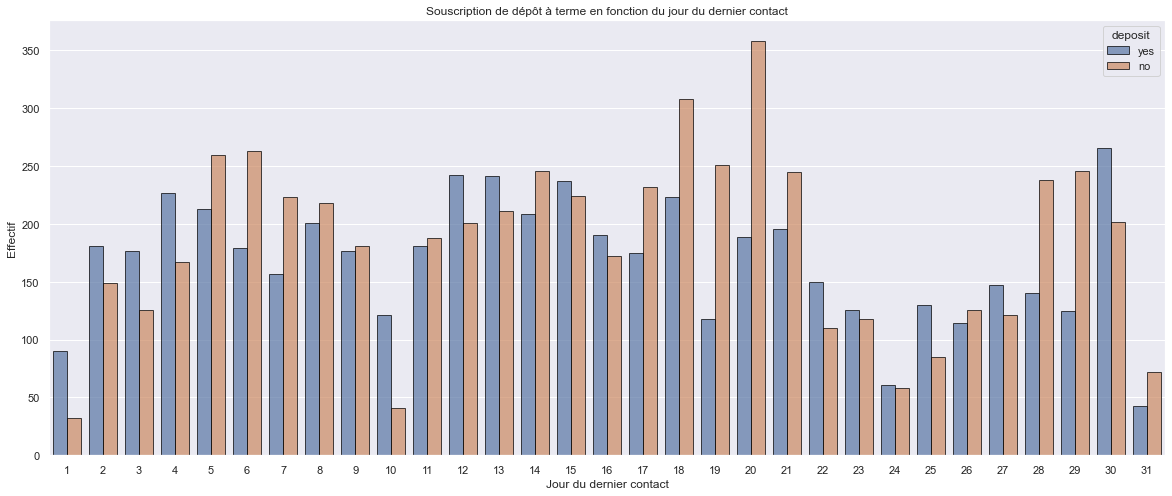

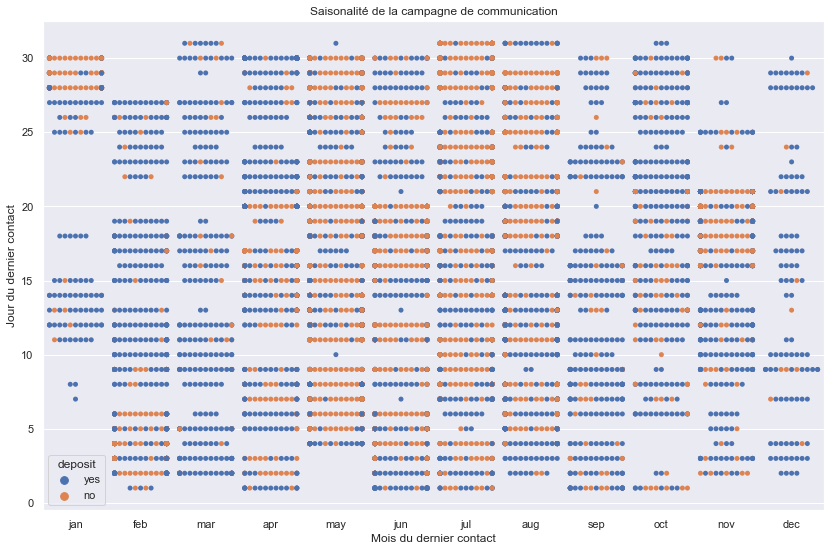

In [15]:
#SAISONNALITE DE LA CAMPAGNE

plt.figure(figsize=(10,5))
sns.countplot(x="month",hue="deposit",data=df_clean,edgecolor="black", alpha=0.7,order=("jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"))
plt.title('Souscription de dépôt à terme en fonction du mois du dernier contact')
plt.xlabel("Mois du dernier contact")
plt.ylabel('Effectif')
plt.show()


# Test du Khi 2 de la variable "month"
table = pd.crosstab(df_clean['month'],df_clean['deposit']) 
resultats_test = chi2_contingency(table)
statistique = resultats_test[0]
p_valeur = resultats_test[1]
degre_liberte = resultats_test[2]

print("Test du Khi 2 entre les variables month et deposit :")
print("P-value: ", p_valeur)
print("V de Cramer : ", V_Cramer(table, df_clean.shape[0]))
print ("La p-value est inférieure à 5% donc on rejette l'hypothèse selon laquelle le mois du dernier contact n'influe pas sur deposit")

plt.figure(figsize=(20,8))
sns.countplot(x="day",hue="deposit",data=df_clean,edgecolor="black", alpha=0.7)
plt.title('Souscription de dépôt à terme en fonction du jour du dernier contact')
plt.xlabel("Jour du dernier contact")
plt.ylabel('Effectif')
plt.show()

plt.figure(figsize=(14,9))
sns.swarmplot(x="month",y="day",hue="deposit",data=df_clean,order=("jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"))
plt.title('Saisonalité de la campagne de communication')
plt.xlabel("Mois du dernier contact")
plt.ylabel('Jour du dernier contact')
plt.show();

Présence d'une saisonalité pour la campagne de communication. Les périodes qui ont générées les meilleurs taux de souscriptions sont les suivantes : de mi-février à fin mars, de septembre à la mi-novembre puis en décembre.
Tandis que la periode de Mai à fin Août serait à proscrire.
La saisonalité est surtout expliquée par le mois plus que par le jour du contact

**Conclusions de la Dataviz**

1. Profil type du client ayant souscrit un dépôt à terme
- au niveau de l'âge, ce sont les clients ayant moins de 30 ans ou plus de 60 ans les plus appétents
- au niveau de la profession, ce sont les étudiants et les retraités qui semblent 
le plus souscrire au dépôt à terme.A contrario, les ouvriers et les personnes travaillant dans les services 
semblent moins intéressés par le produit
- au niveau du statut marital, les célibataires paraissent plus intéressés par le produit que les personnes mariées
- au niveau des études, les clients ayant fait des études supérieures paraissent plus intéressées par le produit
- les clients qui n'ont pas de prêt immobilier sont beaucoup plus appétents au produit, probablement parce que
les clients qui ont un prêt immobilier ont une capacité d'épargne inférieure à cause du remboursement de leur crédit
- de la même façon, les clients détenteurs d'un prêt personnel sont moins appétents au dépôt à terme
- les clients qui ont des soldes plus élevés sont plus appétents au produit, ce qui parait logique puisque la 
souscription d'un dépôt à terme nécessite de déposer et de bloquer un certain montant

2. Enseignements au niveau de la campagne marketing :
- les appels qui ont été passés de mi-février à fin mars, de septembre à la mi-novembre puis en décembre sont ceux qui ont abouti à de meilleurs taux de souscription. Le mois de mai (qui a été le mois où le plus d'appels ont été réalisés) n'est pas du tout un bon mois en terme de taux de souscription
- les clients qui ont été appelés 1 seule fois pendant la campagne sont plus susceptibles de souscrire au produit
que ceux qui ont été appelés plusieurs fois
- plus la durée du dernier appel est longue, plus le client a de chance de souscrire au produit. 72% des appels qui
ont duré plus de 5 mn ont donné lieu à une soucription de produit (contre 29% des appels de moins de 5 mn).
Ce qui parait logique, plus le client est intéressé par le produit, plus il se renseigne et plus l'appel va durer.
A contrario, un client pas du tout intéressé va écourter l'appel
- la campagne semble avoir mieux fonctionnée sur les clients qui ont été appelés sur leur téléphone portable plutôt
que sur leur téléphone fixe
- ceux qui ont été contactés lors d'une campagne précédente sont plus intéressés par le produit
Et même plus précisément, ceux qui ont souscrit au produit lors d'une précédente campagne sont beaucoup plus 
susceptibles de souscrire à nouveau au produit

3. Recommandations pour la prochaine campagne :
- cibler en priorité les clients : de moins de 30 ans ou plus de 60 ans, ayant au moins 800 euros de solde et
n'ayant pas de prêt immobilier, ni de prêt personnel
- il faudrait concentrer les appels de mi-février à avril puis de septembre à décembre. Eviter les appels en mai et 
durant les vacances d'été
- appeler en priorité les clients qui ont déjà été ciblés lors de la campagne précédente ou encore mieux (si les
volumes sont suffisants), appeler ceux qui ont déjà souscrit au produit lors d'une campagne précédente